In [1]:
import os
import numpy as np
import pandas as pd
from transformers import pipeline


def read_excel(excel_file, sheet_name="posts"):
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    return df

def init_sentiment_analyzer_pipeline(model='CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment'):
    sa = pipeline('text-classification', model=model)
    return sa

def init_language_detection_pipeline(model='papluca/xlm-roberta-base-language-detection'):
    ld = pipeline('text-classification', model=model)
    return ld


In [2]:
df = read_excel("pilot.xlsx")
print(f"Original data shape: {df.shape}")

print("Loading sentiment analysis pipeline...")
sa_pipeline = init_sentiment_analyzer_pipeline()
print("Loading language detection pipeline...")
ld_pipeline = init_language_detection_pipeline()
print("Pipelines loaded successfully.")

if not os.path.exists("arabic_posts.csv"):
    posts = df['post'].tolist()
    languages = ld_pipeline(posts)
    languages = [lang['label'] for lang in languages]
    print(f"Number of posts in each language:\n{df['language'].value_counts()}")
    df = df[df['language'] == 'ar']
    df.to_csv("arabic_posts.csv", index=False)

df = pd.read_csv("arabic_posts.csv")
print(f"Data shape after filtering for Arabic posts: {df.shape}")

if not os.path.exists("arabic_posts_with_sentiments.csv"):
    posts = df['post'].tolist()
    sentiments = sa_pipeline(posts)
    sentiments = [sent['label'] for sent in sentiments]
    sentiments_polarity = [sent['score'] for sent in sentiments]
    df['sentiment'] = sentiments
    df['polarity'] = sentiments_polarity
    print(f"Number of posts in each sentiment:\n{df['sentiment'].value_counts()}")
    df.to_csv("arabic_posts_with_sentiments.csv", index=False)

df = pd.read_csv("arabic_posts_with_sentiments.csv")
print(f"Data shape after adding sentiments: {df.shape}")



Original data shape: (154, 13)
Loading sentiment analysis pipeline...
Loading language detection pipeline...
Pipelines loaded successfully.
Data shape after filtering for Arabic posts: (117, 14)
Data shape after adding sentiments: (117, 16)


In [3]:
# Extract hashtags from posts
def extract_hashtags(post, unique=False):
    hashtags = [word for word in post.split() if word.startswith("#")]
    if unique:
        hashtags = list(set(hashtags))
    return hashtags

posts = df['post'].tolist()
hashtags = [extract_hashtags(post, unique=True) for post in posts]
df['hashtags'] = hashtags



In [4]:
# Count the number of occurrences of each hashtag
hashtags_flat = [hashtag for sublist in hashtags for hashtag in sublist]
hashtags_df = pd.DataFrame(hashtags_flat, columns=['hashtag'])
hashtags_counts = hashtags_df['hashtag'].value_counts()
hashtags_df = hashtags_counts.reset_index()
hashtags_df.columns = ['hashtag', 'count']
hashtags_df.head(10)

,hashtag,count
0,#جيش_واحد_شعب_واحد,17
1,#براؤون_يارسول_الله,14
2,#سودان_واحد_موحد,14
3,#معرمة_الكرامة,13
4,#السودان,4
5,#جيش_قوقو,3
6,#مصر,2
7,#خوارج_العصر,2
8,#كلاب_النلر,2
9,#سودان,2


In [5]:
# Add sentiment counts for each hashtag
df_sentiments = df.groupby('sentiment')
hashtags = hashtags_df['hashtag'].tolist()
for sentiment, group in df_sentiments:
    sentiment_count = []
    for hashtag in hashtags:
        count = 0
        for hashtags_list in group['hashtags']:
            if hashtag in hashtags_list:
                count += 1
        sentiment_count.append(count)
    hashtags_df[sentiment] = sentiment_count       

In [6]:
# Classify hashtags as positive, negative, or neutral based on the majority sentiment
hashtags_df['sentiment'] = hashtags_df[['negative', 'neutral', 'positive']].idxmax(axis=1)

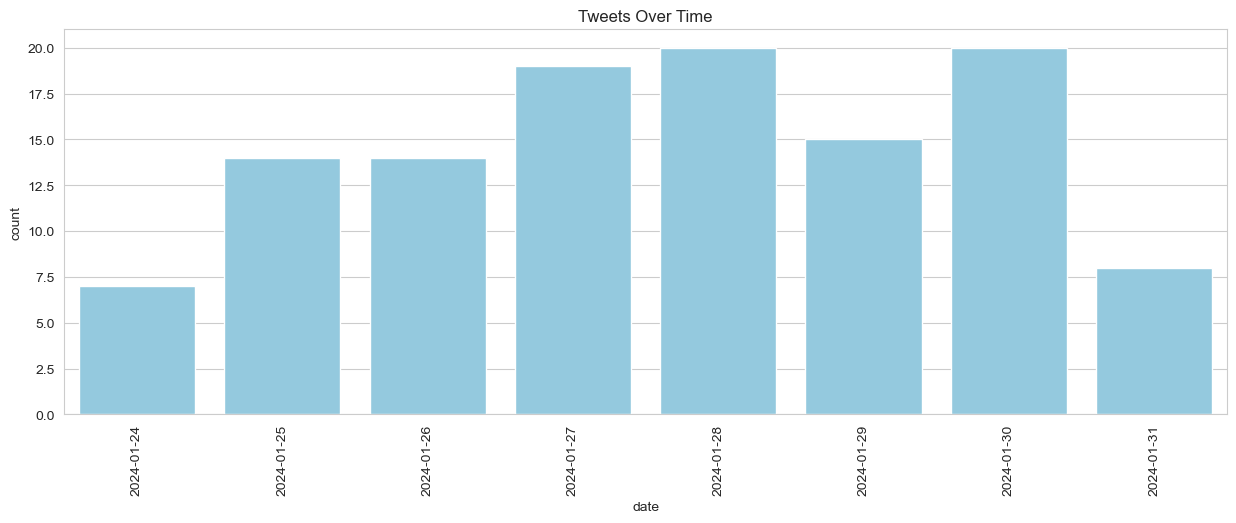

In [7]:
#Distribution of the collected tweets over time (bar chart)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
df['date'] = pd.to_datetime(df['UTC Date'])
df['date'] = df['date'].dt.date
date_counts = df['date'].value_counts().reset_index()
date_counts.columns = ['date', 'count']
date_counts = date_counts.sort_values('date')
plt.figure(figsize=(15, 5))
#all bars to be of the same color
sns.barplot(x='date', y='count', data=date_counts, color='skyblue')
plt.xticks(rotation=90)
plt.title("Tweets Over Time")
plt.show()



In [8]:
#Min and max sentiment polarity for each sentiment
df_sentiments = df.groupby('sentiment')
for sentiment, group in df_sentiments:
    print(f"Sentiment: {sentiment}")
    print(f"Min polarity: {group['polarity'].min()}")
    print(f"Max polarity: {group['polarity'].max()}")
    print("\n")

Sentiment: negative
Min polarity: 0.4728326499462127
Max polarity: 0.997625768184662


Sentiment: neutral
Min polarity: 0.518815815448761
Max polarity: 0.9934932589530944


Sentiment: positive
Min polarity: 0.4232645332813263
Max polarity: 0.994356334209442




In [9]:
#Number of occurrences of the hashtags in all tweets per day
days_df = df.groupby('date')
hashtags = hashtags_df['hashtag'].tolist()
for day, group in days_df:
    day_count = []
    for hashtag in hashtags:
        count = 0
        for hashtags_list in group['hashtags']:
            if hashtag in hashtags_list:
                count += 1
        day_count.append(count)
    hashtags_df[day] = day_count


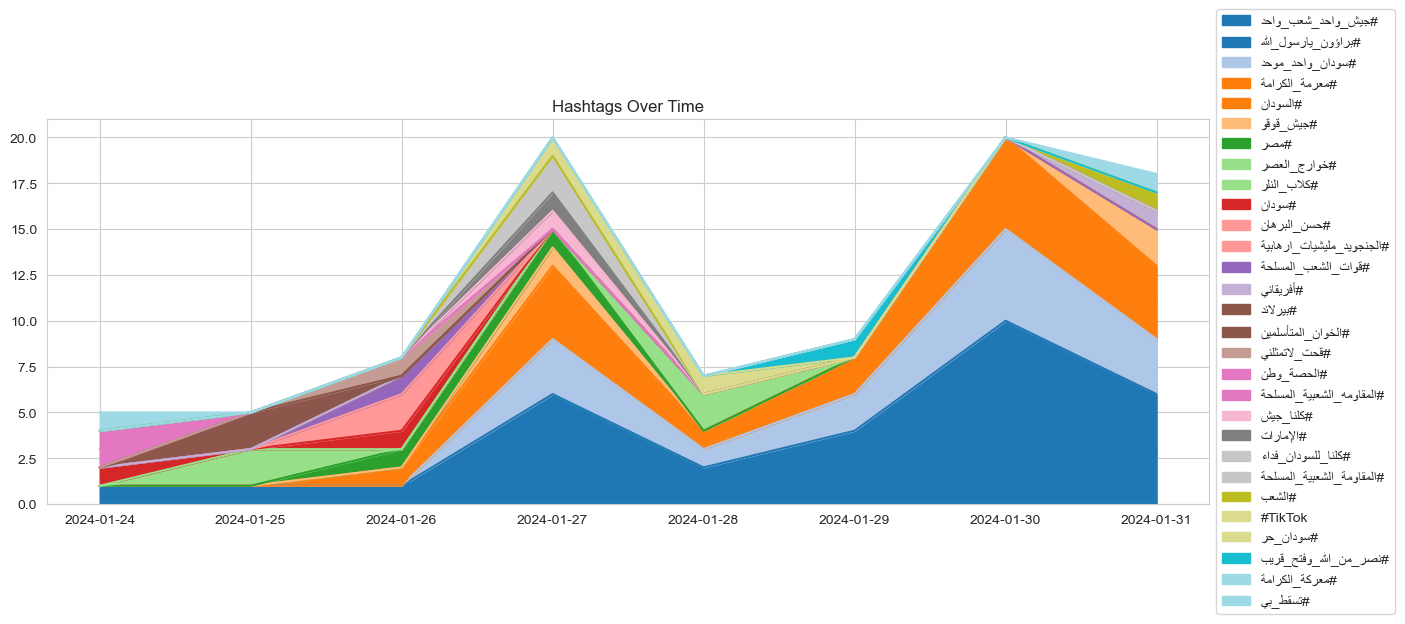

In [11]:
#Plot the distribution of the hashtags over time
import datetime
from bidi.algorithm import get_display
from arabic_reshaper import reshape
cols = [col for col in hashtags_df.columns if type(col) == datetime.date]
cols += ['hashtag']
fig, ax = plt.subplots(figsize=(15, 5))
hashtags_df[cols].set_index('hashtag').T.plot.area(ax=ax, legend=True, colormap='tab20')
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for text in legend.texts:
    text.set_text(get_display(reshape(text.get_text())))
#place the legend outside the plot to the right
plt.title("Hashtags Over Time")
plt.show()



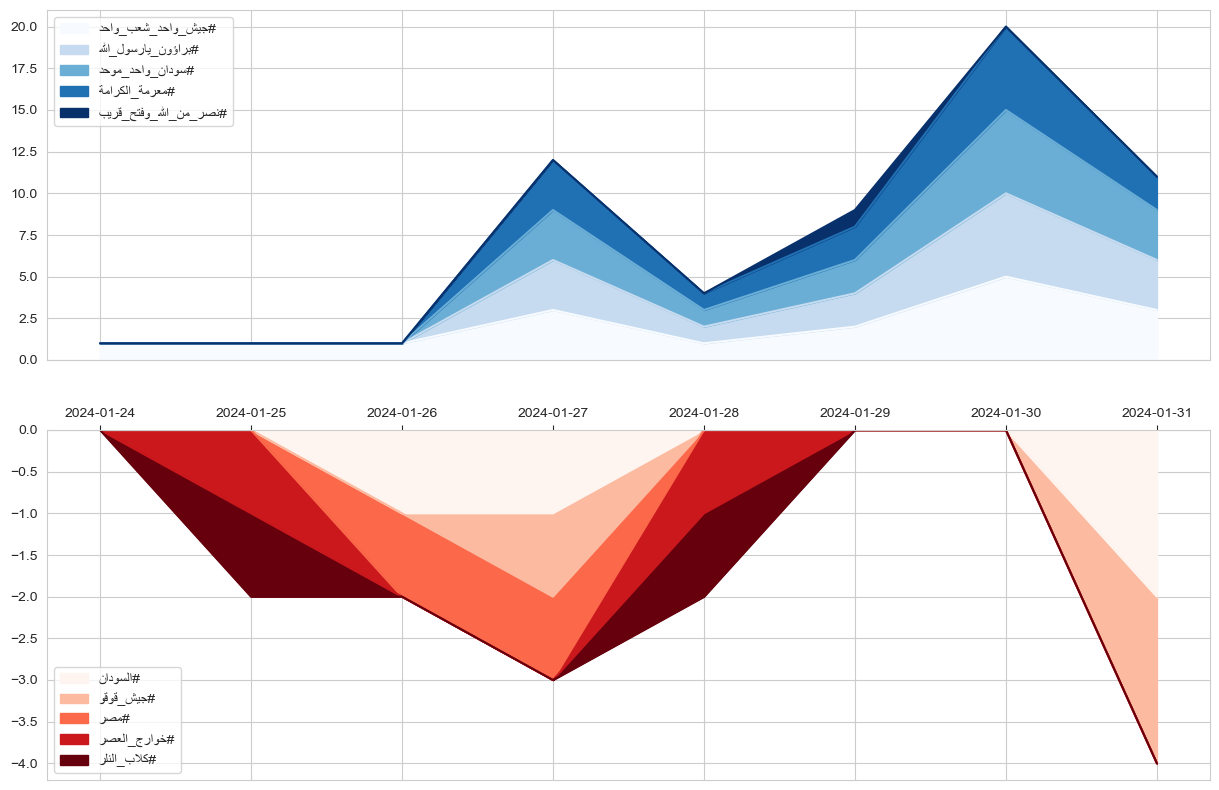

In [12]:
#Plot the distribution of the hashtags over time but this time split the positive and negative hashtags

cols = [col for col in hashtags_df.columns if type(col) == datetime.date]
positive_hashtags = hashtags_df[hashtags_df['sentiment'] == 'positive']
negative_hashtags = hashtags_df[hashtags_df['sentiment'] == 'negative']

positive_hashtags = positive_hashtags.sort_values('count', ascending=False).head(5)
negative_hashtags = negative_hashtags.sort_values('count', ascending=False).head(5)

for col in cols:
    positive_hashtags[col] = positive_hashtags[col]
    negative_hashtags[col] = negative_hashtags[col] * -1
cols += ['hashtag']
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)
ax_up, ax_down = axs
positive_hashtags[cols].set_index('hashtag').T.plot.area(ax=ax_up, legend=False, colormap='Blues')
negative_hashtags[cols].set_index('hashtag').T.plot.area(ax=ax_down, legend=False, colormap='Reds')
ax_down.xaxis.tick_top()
bottom_legend = ax_down.legend()
for text in bottom_legend.texts:
    text.set_text(get_display(reshape(text.get_text())))
top_legend = ax_up.legend()
for text in top_legend.texts:
    text.set_text(get_display(reshape(text.get_text())))
plt.show()

In [13]:
#count the number of tweets for each user in a new dataframe
users_df = df['Username'].value_counts().reset_index()
users_df.columns = ['user', 'count']
users_df = users_df.sort_values('count', ascending=False)

In [14]:
#For each user, calculate the number of positive, negative, and neutral tweets
users = users_df['user'].tolist()
df_users = df.groupby('Username')
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    sentiment_count = []
    for user in users:
        count = 0
        for user_tweets in df_users.get_group(user)['sentiment']:
            if user_tweets == sentiment:
                count += 1
        sentiment_count.append(count)
    users_df[sentiment] = sentiment_count
users_df

,user,count,positive,negative,neutral
0,@lwa84948,10,5,0,5
1,@LebigMohamed,5,0,5,0
2,@TeteBilal67464,3,0,3,0
3,@Mazen0963,3,2,0,1
7,@AbbasArkory,2,0,2,0
...,...,...,...,...,...
35,@JUJYJOL,1,0,1,0
34,@mahsoupy1977,1,0,1,0
33,@Loaf_sama,1,0,1,0
32,@AbdullahHaytahm,1,1,0,0


In [15]:
#Create a dataframe indexed by the date and with columns for each user number of positive, negative, and neutral tweets
dates = df['date'].unique()
users = users_df['user'].tolist()

users_sentiments_df_pos = pd.DataFrame(index=dates, columns=users)
users_sentiments_df_pos = users_sentiments_df_pos.fillna(0)

df_positive = df[df['sentiment'] == 'positive']
df_positive = df_positive.groupby('date')
for date, group in df_positive:
    for user in users:
        users_sentiments_df_pos.at[date, user] = group['Username'].value_counts().get(user, 0)
users_sentiments_df_neg = pd.DataFrame(index=dates, columns=users)
users_sentiments_df_neg = users_sentiments_df_neg.fillna(0)
df_negative = df[df['sentiment'] == 'negative']
df_negative = df_negative.groupby('date')
for date, group in df_negative:
    for user in users:
        users_sentiments_df_neg.at[date, user] = group['Username'].value_counts().get(user, 0)

        

C:\Users\Edin\AppData\Local\Temp\ipykernel_39556\3400167430.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df['date'] = pd.to_datetime(user_df['date'])


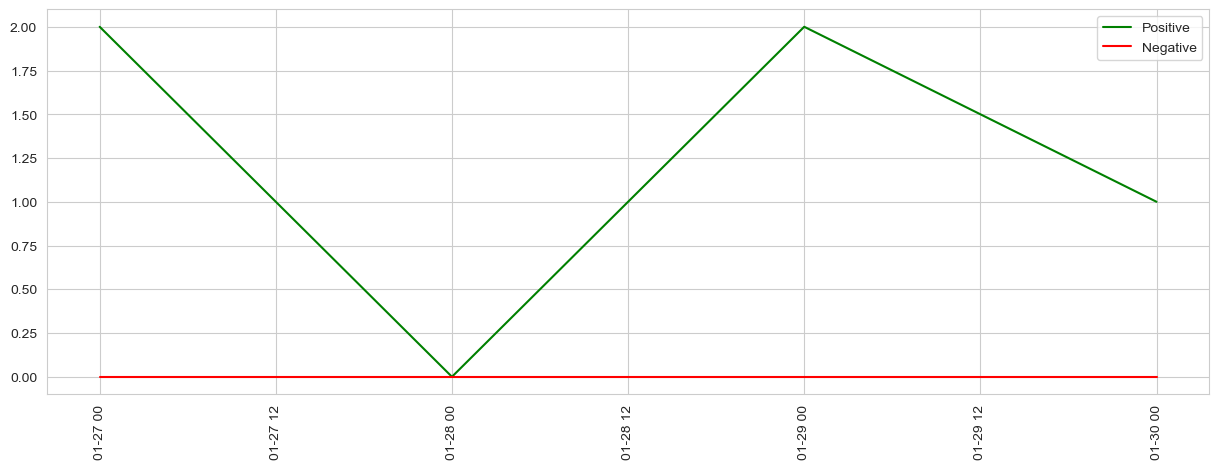

In [16]:
# For a specific user, plot the number of positive and negative tweets over time
target_user = '@lwa84948'
user_df = df[df['Username'] == target_user]
user_df['date'] = pd.to_datetime(user_df['date'])
user_df = user_df.sort_values('date')
user_df = user_df.set_index('date')
user_df = user_df.resample('D').count()
user_df = user_df[['post']]
user_df.columns = ['count']
user_df['positive'] = users_sentiments_df_pos[target_user]
user_df['negative'] = users_sentiments_df_neg[target_user]
user_df = user_df.fillna(0)
user_df = user_df.reset_index()
user_df['date'] = user_df['date'].dt.date
plt.figure(figsize=(15, 5))
plt.plot(user_df['date'], user_df['positive'], label='Positive', color='green')
plt.plot(user_df['date'], user_df['negative'], label='Negative', color='red')
plt.xticks(rotation=90)
plt.legend()